# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:
$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

# Instalaciones, importaciones y declaraciones

In [40]:
!pip install catboost

## Importaciones

In [41]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')
from gensim.sklearn_api import tfidf

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import math
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor
#xgb
import xgboost as xgb

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import copy

In [42]:
nltk.download('stopwords')
#from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
from google.colab import drive 
drive.mount('/content/gdrive')

#4/2wEwWbcwt2SKZzosDJpHk0VR0tAv3TzO3Ox-RkBn08hozQbOsVYOBn4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
train_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/train.csv'
test_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/test.csv'
rta_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/respuestas.csv'
sample_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/sample_submission.csv'

## Inicio de csv

In [45]:
#tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento = pd.read_csv(train_path, index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [46]:
tweets_original_prueba = pd.read_csv(test_path,index_col=['id'])
print(tweets_original_prueba.shape)
tweets_original_prueba.head()

(3263, 3)


,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Calculo resultado (F1)

In [47]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

In [72]:
from sklearn.metrics import f1_score

def F1(pred):
  resultados_de_test = pd.read_csv(rta_path,index_col=['id'])
  return f1_score(resultados_de_test['target'], pred, average='micro')

# Inicio de problema

In [49]:
#esto deberia ahorrar columnas al hacer un BOW
def digitos_en_binario(numero):
    logaritmo2 = math.log2(numero)
    entero = int(logaritmo2)
    entero += 1
    return entero

def transformar_a_vector_binario(numero,digitos):
    nBinario = aBinario(numero)
    digit = len(nBinario)
    while (digit < digitos):
        digit = len(nBinario)
        nBinario.insert(0,0)
    return nBinario

def aBinario(numero):
    numeroDecimal = numero
    numeroBinario = []
    if (numeroDecimal < 2):
        numeroBinario.append(numeroDecimal)
        return numeroBinario
    while numeroDecimal >=2:
        numeroBinario.append(numeroDecimal % 2)
        numeroDecimal //= 2
    numeroBinario.append(numeroDecimal)
    numeroBinario.reverse()
    return numeroBinario

#PRUEBA
#if (digitos_en_binario(63) != 6):
#    print("error en digitos_en_binario")
#bina = aBinario(64)
#if (bina != 6 and bina[0] != 1 and bina[1] != 0 and bina[2] != 0 and bina[3] != 0 and bina[4] != 0 and bina[5] != 0):
#    print("error en aBinario")
#print(transformar_a_vector_binario(64,8))
#TODO OK

In [50]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [51]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    contador = 0
    for palabra in listado:
        if (palabra[0] == '#'):
            contador += 1
    return contador

def cantidad_de_palabras_en_texto(lista,palabra):
    contador = 0
    for elemento in lista:
        if (elemento == palabra):
            contador += 1
    return contador

def localizacion(x,lista):
    if (x == ""):
        return 0
    for i in range(len(lista)):
        palabra = lista[i]
        if (palabra == x):
            return (i + 1)
    return 0

def ubicacionEnLista(x,pos):
    return x[pos]

def BOW_locacion(df,lista,columna):
    cantidadDePalabras = len(lista)
    if (cantidadDePalabras == 0):
        return df
    binarioMaximo = cantidadDePalabras + 1
    digitosBinario = digitos_en_binario(binarioMaximo)
    #for i in range(digitosBinario):
    #    df["palabra_{}".format(i)] = 0
    #df['location'] = df['location'].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    #for j in range(digitosBinario):
    #    df["loc_palabra_{}".format(j)] = df['location'].map(lambda x: ubicacionEnLista(x,j))
    df[columna] = df[columna].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    for j in range(digitosBinario):
        df["{}_palabra_{}".format(columna,j)] = df[columna].map(lambda x: ubicacionEnLista(x,j))
    return df

In [52]:
def eliminar_signos(texto):
    palabra = ""
    for caracter in texto:
        if (caracter < 'a' or caracter > 'z'):
            continue
        palabra += caracter
    return palabra

In [53]:
def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['keyword'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    df['cantidad_de_hashtag_en_texto'] = df['palabras_de_texto'].map(hashtag_en_tweet)

    df['mean_letras_por_palabra'] = df['longitud_de_texto'] / df['cantidad_de_palabras_texto']
    df = df.fillna(value={'mean_letras_por_palabra' : 0})


    
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    #Se requiere pensarlo mas
    #cantidadDePalabrasDelTexto = len(listadoDePalabrasDelTextoDelSetDeEntrenamiento)
    #for i in range(cantidadDePalabrasDelTexto):
    #    df["palabra_{}".format(i)] = 0
    
    df = letra_inicial_Keyword_BOW(df)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [eliminar_signos(item) for item in x])
    
    for palabra in listadoDePalabrasDelTextoDelSetDeEntrenamiento:
        df[palabra] = df['palabras_de_texto'].map(lambda x: cantidad_de_palabras_en_texto(x,palabra))
    
    df = BOW_locacion(df,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,'location')
    df = BOW_locacion(df,listadoDePalabrasDelKeywordDelSetDeEntrenamiento,'keyword')
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = TfidfVectorizer.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #for col in df_tfidf.columns():
    #    df = df.join(df_tfidf[col])
    #df.join(df_tfidf)#mal planteado
    
    df = df.drop(columns=['keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [54]:
def extraer_palabras(serie):
    URL_INICIO = "http"
    lista = []
    #dic = {}
    for listado in serie:
        for elemento in listado:
            palabra = eliminar_signos(elemento)
            #la mayoria de las palabras en ingles tienen una esperansa de 4.8773 caracteres con varianza de 2.6171
            longitud = len(palabra)
            #simbolos = ('0','1','2','3','4','5','6','7','8','9','#','/','','"','@',';','?','[','(','{','.','!','$','&','*','-')
            if (palabra in lista or longitud < 2 or palabra[:4] == URL_INICIO or palabra in stopwordEnglis):
                #dic[elemento] += 1
                continue
            #dic[elemento] = 1
            lista.append(elemento)
    #resultado = []
    #max = 0
    #for palabra in lista:
    #    max = dic[palabra]
    #    if (dic[palabra] < 800):
    #        continue
    #    resultado.append(palabra)
    return lista

def generar_lista(x,lista):
    if (x in lista or x == ""):
        return
    lista.append(x)
    return

## ABRO LOS SETS

In [55]:
import copy

#train
train_label = tweets_original_entrenamiento['target']
train_set = copy.deepcopy(tweets_original_entrenamiento)
train_set = train_set.drop(columns=['target'])
#test
test_set = copy.deepcopy(tweets_original_prueba)

# PROCESADO DE SET

In [56]:
def listadoDeElementos(df1,df2,columna):
    df1[columna].fillna("", inplace=True)
    df2[columna].fillna("", inplace=True)
    seriePalabrasDf1 = df1[columna].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    listadoDePalabrasDelDf1 = extraer_palabras(seriePalabrasDf1)
    seriePalabrasDf2 = df2[columna].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    listadoDePalabrasDelDf2 = extraer_palabras(seriePalabrasDf2)
    lista_final = {}
    for elem in listadoDePalabrasDelDf1:
        elemento = eliminar_signos(elem)
        if (not elemento in listadoDePalabrasDelDf2):
            continue
        if (elemento in lista_final.keys()):
            lista_final[elemento] += 1
        else:
            lista_final[elemento] = 1
    
    listadoDePalabras = []
    for clave in lista_final.keys():
        if (lista_final[clave] <= 2):
            continue
        listadoDePalabras.append(clave)
    
    print(len(listadoDePalabras))
    return listadoDePalabras

In [57]:
def fusionarTextoConKeyword(df1,df2):
    df1['text'] = df1['text'] + " " + df1['keyword']
    df2['text'] = df2['text'] + " " + df2['keyword']
    return df1,df2
train_set,test_set = fusionarTextoConKeyword(train_set,test_set)

In [58]:
#Recordar esta celda debe ser activada despues de abrir los sets si no lanza error
listadoDePalabrasDelTexto = listadoDeElementos(train_set,test_set,'text')

141


In [59]:
listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento = listadoDeElementos(train_set,test_set,'location')

39


In [60]:
listadoDePalabrasDelKeywordDelSetDeEntrenamiento = listadoDeElementos(train_set,test_set,'keyword')

0


In [61]:
#train_set = preparar_df(train_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set = preparar_df(train_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,mean_letras_por_palabra,letra_0,letra_1,letra_2,letra_3,burned,im,amp,news,edm,cant,mom,mma,manchester,th,today,ill,ir,dance,possible,shell,island,theyre,job,official,rip,wreck,mlb,airport,aircraft,ago,esp,theres,whats,hes,...,historic,richmond,jam,saipan,cnbc,wo,genocide,utc,sm,jst,ak,veterans,chaos,miami,saturday,cbs,married,sh,sundays,structure,pin,chest,farrakhan,boston,wreckage,georgia,alps,hmm,uniform,nigeria,structural,selfies,towel,conclusively,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
#test_set = preparar_df(test_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set = preparar_df(test_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
print(test_set.shape)
test_set.head()

(3263, 157)


,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,mean_letras_por_palabra,letra_0,letra_1,letra_2,letra_3,burned,im,amp,news,edm,cant,mom,mma,manchester,th,today,ill,ir,dance,possible,shell,island,theyre,job,official,rip,wreck,mlb,airport,aircraft,ago,esp,theres,whats,hes,...,historic,richmond,jam,saipan,cnbc,wo,genocide,utc,sm,jst,ak,veterans,chaos,miami,saturday,cbs,married,sh,sundays,structure,pin,chest,farrakhan,boston,wreckage,georgia,alps,hmm,uniform,nigeria,structural,selfies,towel,conclusively,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
#SOLO USAR SI SE SOSPECHA DE ERROR EN PROCESAMIENTO DE DATOS (si existen str en las columnas)
def verificador_de_contenido_string_en_columnas():
    for n in test_set.columns:
        try:
            #test_set[n] = pd.to_numeric(test_set[n])
            test_set[n].astype(int)
        except:
            print(n)
    for n in train_set.columns:
        try:
            #train_set[n] = pd.to_numeric(train_set[n])
            train_set[n].astype(int)
        except:
            print(n)

def verificador_de_columnas():#NO USAR por algun motivo falla en su funcion
    colTest = test_set.columns
    colTrain = train_set.columns
    print(colTest)
    print(colTrain)
    if (len(colTest) != len(colTrain)):
        print("Error en cantidad de columnas")
    for n in colTest:
        try:
            colTrain[n]
        except:
            print("error de nombre de columna",n)

In [64]:
def verificador_de_valoracion_de_columnas(df):
    nulas = []
    colum = df.columns 
    contador = 0
    tot = test_set['longitud_de_texto'].count()
    for col in colum:
        sumatoria = test_set[col].sum()
        if (sumatoria != 0 and not(sumatoria == tot and test_set[col].max() == 1)):
            continue
        contador += 1
        nulas.append(col)
        #print(col)
    print("columnas con puros ceros o unos: ",contador)
    return nulas
print("test set")
n1 = verificador_de_valoracion_de_columnas(test_set)
print("train set")
n2 = verificador_de_valoracion_de_columnas(train_set)

test set
columnas con puros ceros o unos:  4
train set
columnas con puros ceros o unos:  4


In [65]:
def desacerse_de_columnasNulas_en_comun(df1,df2,l1,l2):
    colABorrar = []
    for elemento in l1:
        if (not elemento in l2):
            continue
        colABorrar.append(elemento)
    print(colABorrar)
    df1 = df1.drop(columns=colABorrar)
    df2 = df2.drop(columns=colABorrar)
    return df1,df2
if (n1 != 0 and n2 != 0):
    train_set,test_set = desacerse_de_columnasNulas_en_comun(train_set,test_set,n1,n2)

['location_palabra_0', 'location_palabra_1', 'location_palabra_2', 'location_palabra_5']


In [66]:
def ensamble(df,n,prediccion,desplazamiento=0):
    #-0.5 < desplazamiento < 0.5
    prediccion += desplazamiento
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    """para ensambles redondeados"""
    df['target'] = df['target'].div(n).round()
    return df

def calcular_resultado_de_prediccion_segun_norma(df,n):
    """para ensambles sin redondeo"""
    num = n**0.5
    df['target'] = df['target'].div(num).round()
    return df

# BUSQUEDA DE HIPER-PARAMETROS

In [67]:
def F1_local(predict, verdadero):
    return f1_score(verdadero, predict, average='micro')

In [68]:
from sklearn.metrics import mean_squared_error

def busqueda_binaria_de_maximo(listasDeParametros,nParametros,n=0,funcion=None):
    if (n == len(listasDeParametros)):
        parametros = []
        for i in range(n):
            parametros.append(listasDeParametros[i][nParametros[i]])
        print(parametros)
        #return ultimo_Hiper_Parametro_catboost(parametros),parametros
        return funcion(parametros),parametros
    
    posIzq = 0
    posDer = len(listasDeParametros[n])-1
    
    nParametros[n] = posIzq
    izq,parametrosOptimos = busqueda_binaria_de_maximo(listasDeParametros,nParametros,n+1,funcion)
    
    nParametros[n] = posDer
    der,parametrosOptimos = busqueda_binaria_de_maximo(listasDeParametros,nParametros,n+1,funcion)
    
    while posIzq <= posDer:
        posMedio = (posIzq+posDer)//2

        if (posDer - posIzq <= 1):
            if (izq > der):
                return izq,parametrosOptimos
            return der,parametrosOptimos

        elif izq > der:
            posDer = posMedio
            nParametros[n] = posDer
            der,parametrosOptimos = busqueda_binaria_de_maximo(listasDeParametros,nParametros,n+1,funcion)
    
        else:
            posIzq = posMedio
            nParametros[n] = posIzq
            izq,parametrosOptimos = busqueda_binaria_de_maximo(listasDeParametros,nParametros,n+1,funcion)
        
    return -1,[-1]

def ultimo_Hiper_Parametro_catboost(parametros):

    X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_label, test_size=0.2, random_state=123)

    model = CatBoostClassifier(iterations=parametros[0],
                              learning_rate=parametros[1],
                              depth=parametros[2])

    model.fit(X_train, y_train)

    predicts = model.predict(X_valid)

    maximo_local = F1_local(predicts, y_valid.tolist())
    ######verificacion de hiperparamentros
    #rmse = np.sqrt(mean_squared_error(y_valid, predicts))

    print(maximo_local)
    print("--------")
    return maximo_local

def ultimo_Hiper_Parametro_XGBoost(parametros):


    X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_label, test_size=0.2, random_state=123)

    xgb_reg = xgb.XGBClassifier(max_depth = parametros[0], 
                               colsample_bytree = parametros[1], 
                               learning_rate = parametros[2], 
                               alpha = parametros[3],
                               objetive = 'reg:squarederror')
    
    xgb_reg.fit(X_train, y_train)

    predicts = xgb_reg.predict(X_valid).round()
    
    maximo_local = F1_local(predicts, y_valid.tolist())
    ######verificacion de hiperparamentros
    #rmse = np.sqrt(mean_squared_error(y_valid, predicts))

    print(maximo_local)
    print("--------")
    return maximo_local

def ultimo_Hiper_Parametro_Ramdom_forest(parametros):
    ##dividiendo en set de validacion y train
    X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_label, test_size=0.2, random_state=123)
    
    rf = RandomForestClassifier(random_state=parametros[0],
                               n_estimators = parametros[1],
                               max_features = parametros[2],
                               max_depth =parametros[3],
                               min_samples_split=parametros[4])
    rf.fit(X_train, y_train)

    predicts = rf.predict(X_valid)
  
    maximo_local = F1_local(predicts, y_valid.tolist())
    ######verificacion de hiperparamentros
    #rmse = np.sqrt(mean_squared_error(y_valid, predicts))

    print(maximo_local)
    print("--------")
    return maximo_local

def ultimo_Hiper_Parametro_LigthBM(parametros):

    X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_label, test_size=0.2, random_state=123)

    #print(parametros)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    params = {'num_leaves': parametros[0], 
              'min_child_samples': parametros[1], 
              'min_child_weight': parametros[2],
              'subsample': parametros[3], 
              'colsample_bytree': parametros[4],
              'reg_alpha': parametros[5],
              'reg_lambda': parametros[6]
    }
    

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets = lgb_valid,
                    num_boost_round=parametros[7])
                    #early_stopping_rounds=parametros[8])

    ######verificacion de hiperparamentros
    predicts = gbm.predict(X_valid, num_iteration=gbm.best_iteration).round()

    #print(y_valid.tolist())
    #print(predicts)

    maximo_local = F1_local(predicts, y_valid.tolist())

    ######verificacion de hiperparamentros
    #rmse = np.sqrt(mean_squared_error(y_valid, predicts))

    print(maximo_local)
    print("--------")
    return maximo_local

# CATBOOST

In [73]:
from catboost import CatBoostClassifier

#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria():
    parametrosCatboostIter = list(range(3,11,1))
    parametrosCatboostLR = list(range(30,81,1))
    for i in range(len(parametrosCatboostLR)):
        parametrosCatboostLR[i] /= 100
    parametrosCatboostProfundidad = list(range(6,16,1))
    listaDeParametros = [parametrosCatboostIter,parametrosCatboostLR,parametrosCatboostProfundidad]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_catboost)
    print("maximo {} parametros (iter,learning,profundidad) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria()

[3, 0.3, 6]
0:	learn: 0.6732107	total: 4.47ms	remaining: 8.95ms
1:	learn: 0.6581176	total: 9.11ms	remaining: 4.56ms
2:	learn: 0.6496015	total: 13.4ms	remaining: 0us
0.6362442547603414
--------
[3, 0.3, 15]
0:	learn: 0.6636116	total: 324ms	remaining: 647ms
1:	learn: 0.6312562	total: 606ms	remaining: 303ms
2:	learn: 0.6200523	total: 885ms	remaining: 0us
0.6579120157583717
--------
[3, 0.3, 10]
0:	learn: 0.6664791	total: 12.5ms	remaining: 25ms
1:	learn: 0.6538807	total: 16.8ms	remaining: 8.39ms
2:	learn: 0.6385723	total: 29.1ms	remaining: 0us
0.6342744583059751
--------
[3, 0.3, 12]
0:	learn: 0.6664186	total: 43.6ms	remaining: 87.3ms
1:	learn: 0.6407897	total: 86.6ms	remaining: 43.3ms
2:	learn: 0.6270681	total: 128ms	remaining: 0us
0.6565988181221274
--------
[3, 0.3, 13]
0:	learn: 0.6662633	total: 74.4ms	remaining: 149ms
1:	learn: 0.6426030	total: 147ms	remaining: 73.6ms
2:	learn: 0.6357768	total: 168ms	remaining: 0us
0.6375574523965857
--------
[3, 0.3, 14]
0:	learn: 0.6637653	total: 14

In [75]:
fresultados_de_prediccion = pd.read_csv(sample_path,index_col=['id'])
cantidadDePredicciones = 0
#catboost
for iter in range(7,8,1):
    for lR in range(62,66,1):
        learningRate = lR / 100
        for profundidad in range(13,16):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            print("prediccion = ",cantidadDePredicciones)

#cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion,0.2)
print(F1(resultados_de_prediccion))

0:	learn: 0.4775497	total: 79.3ms	remaining: 476ms
1:	learn: 0.4711463	total: 91.6ms	remaining: 229ms
2:	learn: 0.4682328	total: 167ms	remaining: 223ms
3:	learn: 0.4657784	total: 189ms	remaining: 142ms
4:	learn: 0.4591319	total: 289ms	remaining: 116ms
5:	learn: 0.4518898	total: 373ms	remaining: 62.1ms
6:	learn: 0.4505101	total: 386ms	remaining: 0us
prediccion =  1
0:	learn: 0.4768987	total: 154ms	remaining: 923ms
1:	learn: 0.4674369	total: 302ms	remaining: 756ms
2:	learn: 0.4619593	total: 458ms	remaining: 610ms
3:	learn: 0.4589095	total: 498ms	remaining: 374ms
4:	learn: 0.4570285	total: 506ms	remaining: 202ms
5:	learn: 0.4556776	total: 654ms	remaining: 109ms
6:	learn: 0.4548526	total: 666ms	remaining: 0us
prediccion =  2
0:	learn: 0.4754129	total: 305ms	remaining: 1.83s
1:	learn: 0.4629245	total: 604ms	remaining: 1.51s
2:	learn: 0.4577163	total: 888ms	remaining: 1.18s
3:	learn: 0.4563836	total: 896ms	remaining: 672ms
4:	learn: 0.4549234	total: 903ms	remaining: 361ms
5:	learn: 0.4497101

In [76]:
#resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
resultados_de_prediccion = pd.read_csv(sample_path,index_col=['id'])
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=7,
                          learning_rate=0.66,
                          depth=12)
# Fit model
model.fit(train_set, train_label)
# Get predictions
predicion = model.predict(test_set)

cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,
                                                           0,
                                                           predicion,
                                                           0.20)

0:	learn: 0.4785225	total: 49.7ms	remaining: 298ms
1:	learn: 0.4662454	total: 98.2ms	remaining: 246ms
2:	learn: 0.4597554	total: 147ms	remaining: 196ms
3:	learn: 0.4533963	total: 195ms	remaining: 146ms
4:	learn: 0.4523863	total: 200ms	remaining: 79.8ms
5:	learn: 0.4519231	total: 202ms	remaining: 33.6ms
6:	learn: 0.4481485	total: 258ms	remaining: 0us


In [77]:
resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)
print(cantidadDePredicciones)
resultados_de_prediccion

1


,target
id,
0,1.00
2,1.00
3,1.00
9,1.00
11,1.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [ ]:
print(F1(resultados_de_prediccion))


In [ ]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

# XGBoost

In [ ]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

In [ ]:
test_set = eliminarErrorDeValores(test_set)
train_set = eliminarErrorDeValores(train_set)

In [ ]:
######verificacion de hiperparamentros
cantidadDePredicciones = 0
resultadoDePrediccionXGBoost = pd.read_csv(sample_path,index_col=['id'])
for profundidad in range(6,8,1):
    for tree in range(40,81,20):
        colsampleTree = tree / 100
        for lR in range(10,81,20):
            learningRate = lR / 100
            for alpha in range(5,16,5):
                xgb_reg = xgb.XGBRegressor(max_depth = profundidad, 
                                           colsample_bytree = colsampleTree, 
                                           learning_rate = learningRate, 
                                           alpha = alpha,
                                           objetive = 'reg:squarederror')
                
                xgb_reg.fit(train_set, train_label)
                predicion = xgb_reg.predict(test_set).round()
                cantidadDePredicciones,resultados_de_prediccion = ensamble(resultadoDePrediccionXGBoost,cantidadDePredicciones,predicion)
                print("prediccion = ",cantidadDePredicciones)

#print(F1(resultados_de_prediccion))

[04:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  1
[04:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  2
[04:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  3
[04:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  4
[04:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  5
[04:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  6
[04:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prediccion =  7

In [ ]:
#los rangos se van afinando segun corren las pruebas
def busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria():
    parametrosXGBoostProfundidad = list(range(13,16,1))
    parametrosXGBoostColSample = list(range(50,61,2))
    for i in range(len(parametrosXGBoostColSample)):
        parametrosXGBoostColSample[i] /= 100
    parametrosXGBoostLR = list(range(50,61,2))
    for i in range(len(parametrosXGBoostLR)):
        parametrosXGBoostLR[i] /= 100
    parametrosXGBoostAlpha = list(range(9,12,1))
    listaDeParametros = [parametrosXGBoostProfundidad,parametrosXGBoostColSample,parametrosXGBoostLR,parametrosXGBoostAlpha]
    maximo,parametros =busqueda_binaria_de_maximo(listaDeParametros,
                                                   [0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_XGBoost)
    print("maximo {} parametros (max_depth,colSample,learning_rate,alpha) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria()

[13, 0.5, 0.5, 9]
0.6428102429415627
--------
[13, 0.5, 0.5, 11]
0.6428102429415627
--------
[13, 0.5, 0.5, 10]
0.6428102429415627
--------
[13, 0.5, 0.6, 9]
0.6401838476690742
--------
[13, 0.5, 0.6, 11]
0.6401838476690742
--------
[13, 0.5, 0.6, 10]
0.6401838476690742
--------
[13, 0.5, 0.54, 9]
0.6441234405778069
--------
[13, 0.5, 0.54, 11]
0.6441234405778069
--------
[13, 0.5, 0.54, 10]
0.6441234405778069
--------
[13, 0.5, 0.52, 9]
0.654629021667761
--------
[13, 0.5, 0.52, 11]
0.654629021667761
--------
[13, 0.5, 0.52, 10]
0.654629021667761
--------
[13, 0.6, 0.5, 9]
0.649376231122784
--------
[13, 0.6, 0.5, 11]
0.649376231122784
--------
[13, 0.6, 0.5, 10]
0.649376231122784
--------
[13, 0.6, 0.6, 9]
0.6401838476690742
--------
[13, 0.6, 0.6, 11]
0.6401838476690742
--------
[13, 0.6, 0.6, 10]
0.6401838476690742
--------
[13, 0.6, 0.54, 9]
0.6454366382140512
--------
[13, 0.6, 0.54, 11]
0.6454366382140512
--------
[13, 0.6, 0.54, 10]
0.6454366382140512
--------
[13, 0.6, 0.52, 9

In [ ]:
xgb_reg = xgb.XGBClassifier(max_depth = 14, 
                           colsample_bytree = 0.52, 
                           learning_rate = 0.52, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

In [ ]:
xgb_reg.fit(train_set, train_label)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.52, gamma=0,
              learning_rate=0.52, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              objetive='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [24]:
result = pd.read_csv(sample_path,index_col=['id'])
print(result.shape)

(3263, 1)


In [ ]:
predicts = xgb_reg.predict(test_set)

#predicts += 0.2
predicts = predicts.round()
result['target'] = predicts

resultados_de_prediccion = copy.deepcopy(result)
print(f1(predicts))

0.638369598528961


Con K-FOLDS

In [ ]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.52, 'learning_rate': 0.52, 'max_depth': 14, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))

23                   0.47
Name: test-rmse-mean, dtype: float64


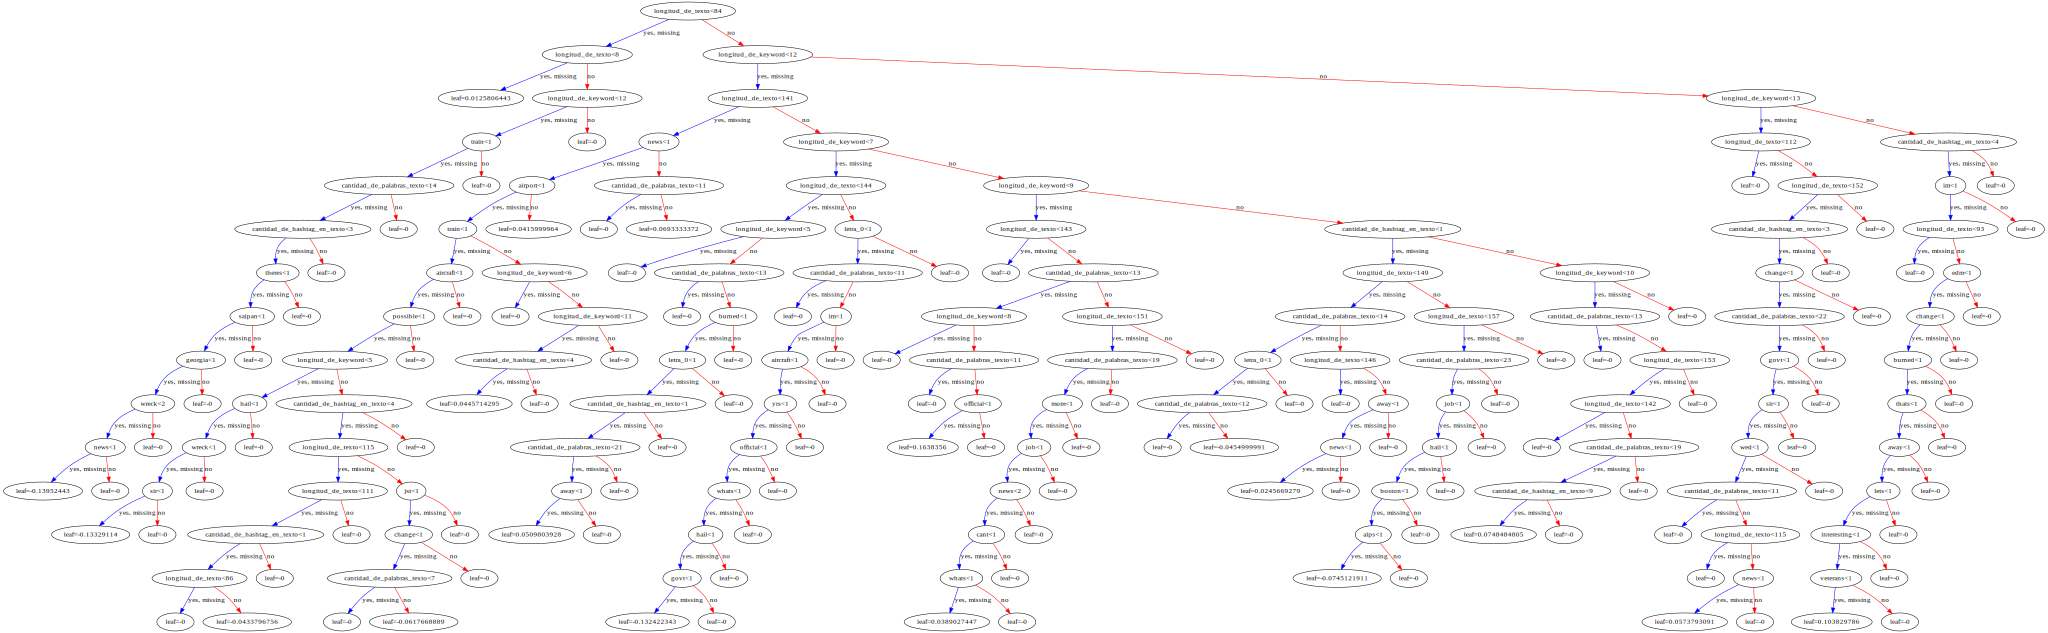

In [ ]:
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

Importancia de cada feature

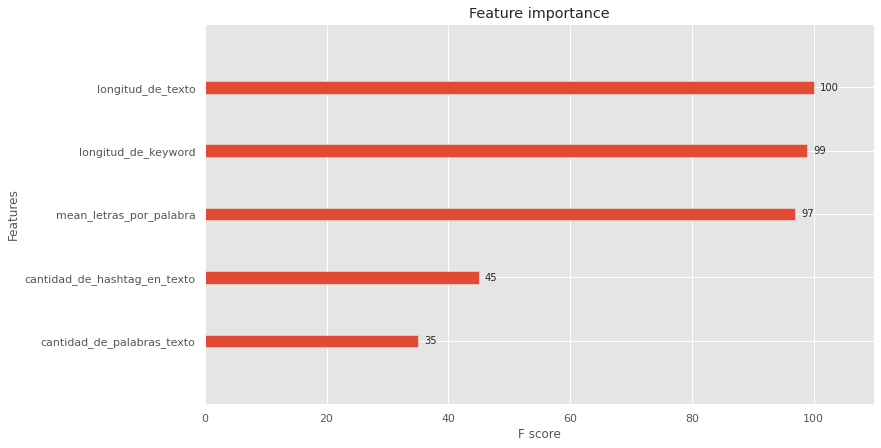

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]

xgb.plot_importance(xg_reg, max_num_features=5)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria():
    parametrosRFRandom_state = list(range(4,200,7))
    parametrosRFn_estimators = list(range(100,5000,500))
    parametrosRFmax_features = list(range(4,15,1))
    parametrosRFmax_depth = list(range(1,51,2))
    parametrosRFmin_samples_split = list(range(2,31,1))
    listaDeParametros = [parametrosRFRandom_state,parametrosRFn_estimators,
                         parametrosRFmax_features,parametrosRFmax_depth,
                         parametrosRFmin_samples_split]
    max,parametros =busqueda_binaria_de_maximo(listaDeParametros,
                                                   [0,0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_Ramdom_forest)
    print("maximo {} parametros (random_state,n_estimators,max_features,max_depth,min_samples_split) {}".format(min,parametros))
busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria()

[4, 100, 4, 1, 2]
0.5771503611293499
--------
[4, 100, 4, 1, 30]
0.5771503611293499
--------
[4, 100, 4, 1, 16]
0.5771503611293499
--------
[4, 100, 4, 1, 23]
0.5771503611293499
--------
[4, 100, 4, 1, 26]
0.5771503611293499
--------
[4, 100, 4, 1, 28]
0.5771503611293499
--------
[4, 100, 4, 1, 29]
0.5771503611293499
--------
[4, 100, 4, 49, 2]
0.6723571897570584
--------
[4, 100, 4, 49, 30]
0.6841759684832567
--------
[4, 100, 4, 49, 16]
0.6848325673013789
--------
[4, 100, 4, 49, 23]
0.6848325673013789
--------
[4, 100, 4, 49, 19]
0.6861457649376231
--------
[4, 100, 4, 49, 21]
0.6848325673013789
--------
[4, 100, 4, 49, 20]
0.6874589625738674
--------
[4, 100, 4, 25, 2]
0.6638214051214708
--------
[4, 100, 4, 25, 30]
0.6651346027577151
--------
[4, 100, 4, 25, 16]
0.6592252133946159
--------
[4, 100, 4, 25, 23]
0.659881812212738
--------
[4, 100, 4, 25, 26]
0.6572554169402495
--------
[4, 100, 4, 25, 28]
0.6585686145764937
--------
[4, 100, 4, 25, 29]
0.6585686145764937
--------
[4,

KeyboardInterrupt: ignored

In [ ]:
rf = RandomForestClassifier(random_state=4, 
                           n_estimators = 100, 
                           max_features = 13,
                           max_depth = 45, 
                           min_samples_split=30)
rf.fit(train_set, train_label)
feature_imp = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), list(train_set.columns)),
             reverse=True)
print("Features sorted by their score:")
print(feature_imp)

Features sorted by their score:
[(0.1968, 'longitud_de_texto'), (0.1961, 'longitud_de_keyword'), (0.1814, 'mean_letras_por_palabra'), (0.1156, 'cantidad_de_palabras_texto'), (0.0443, 'cantidad_de_hashtag_en_texto'), (0.026, 'train'), (0.0168, 'news'), (0.0159, 'wreckage'), (0.0112, 'airport'), (0.0085, 'forest'), (0.0076, 'today'), (0.0076, 'aircraft'), (0.0071, 'outrage'), (0.0059, 'wreck'), (0.0058, 'im'), (0.0053, 'hail'), (0.0052, 'cantidad_de_palabras_keyword'), (0.0051, 'letra_2'), (0.005, 'possible'), (0.005, 'island'), (0.0049, 'letra_1'), (0.0047, 'letra_0'), (0.0045, 'change'), (0.0044, 'burned'), (0.0042, 'letra_3'), (0.004, 'udhampur'), (0.0039, 'richmond'), (0.0039, 'away'), (0.0038, 'song'), (0.0033, 'govt'), (0.0031, 'mom'), (0.0031, 'cliff'), (0.003, 'ebola'), (0.003, 'denver'), (0.0025, 'ago'), (0.0024, 'okay'), (0.0023, 'lets'), (0.0022, 'womens'), (0.0022, 'cant'), (0.0021, 'official'), (0.0021, 'job'), (0.002, 'ceo'), (0.0019, 'yrs'), (0.0018, 'app'), (0.0017, 'upda

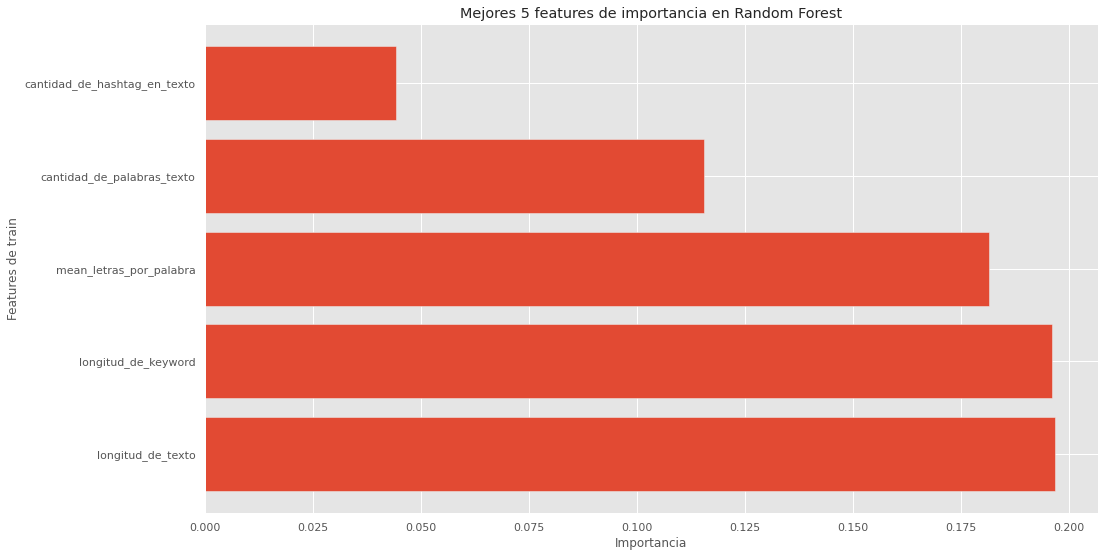

In [ ]:
scores = [x[0] for x in feature_imp][0:5]
features = [x[1] for x in feature_imp][0:5]

plt.barh(features, scores)
plt.ylabel('Features de train')
plt.xlabel('Importancia')
plt.title('Mejores 5 features de importancia en Random Forest')
plt.show()

In [ ]:
predicts = rf.predict(test_set)
result['target'] = predicts
print(f1(predicts))
resultados_de_prediccion = copy.deepcopy(result)

0.6711615078148943


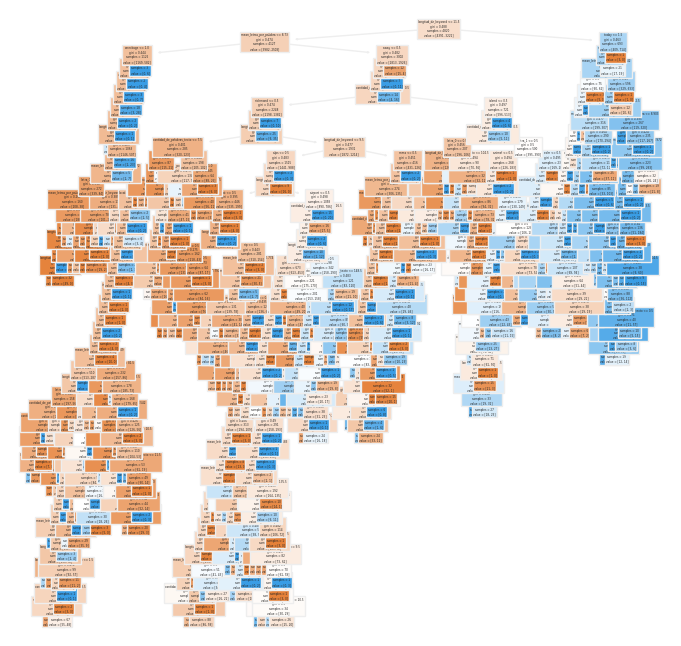

In [ ]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rf.estimators_[0],
               feature_names = train_set.columns,
               filled = True);

Random Hyperparameter Grid

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint

print('Parametros en uso por default:\n')
pprint(rf.get_params())

Parametros en uso por default:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_set, train_label, test_size=0.20, random_state=314, stratify=train_label)


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.2min


KeyboardInterrupt: ignored

In [ ]:
rf_random.best_params_

In [ ]:
rf_fin = RandomForestClassifier(bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100)
rf_fin.fit(X_train, y_train)

preds = rf_fin.predict_proba(test_set).round()
result['target'] = preds
print(F1(result))

1399.0 1861.0 3.0
0.6001716001716002


Grid-Search con Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(train_set, train_label, test_size=0.20, random_state=193, stratify=train_label)

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)


In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  9.2min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [ ]:
rf_fin = RandomForestClassifier(bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100)
rf_fin.fit(train_set, train_label)

preds = rf_fin.predict_proba(test_set).round()
result['target'] = preds
print(F1(result))

resultados_de_prediccion = copy.deepcopy(result)

1399.0 1861.0 3.0
0.6001716001716002


# Redes Neuronales

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
batch_size = 128
num_classes = 1
epochs = 5

In [ ]:
print(train_set.shape)
print(test_set.shape)

(7613, 499)
(3263, 499)


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [ ]:
model.fit(train_set, train_label,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/5


ValueError: ignored

In [ ]:
score = model.evaluate(test_set, train_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: ignored

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_set.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1136256   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,144,577
Trainable params: 1,144,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


........................

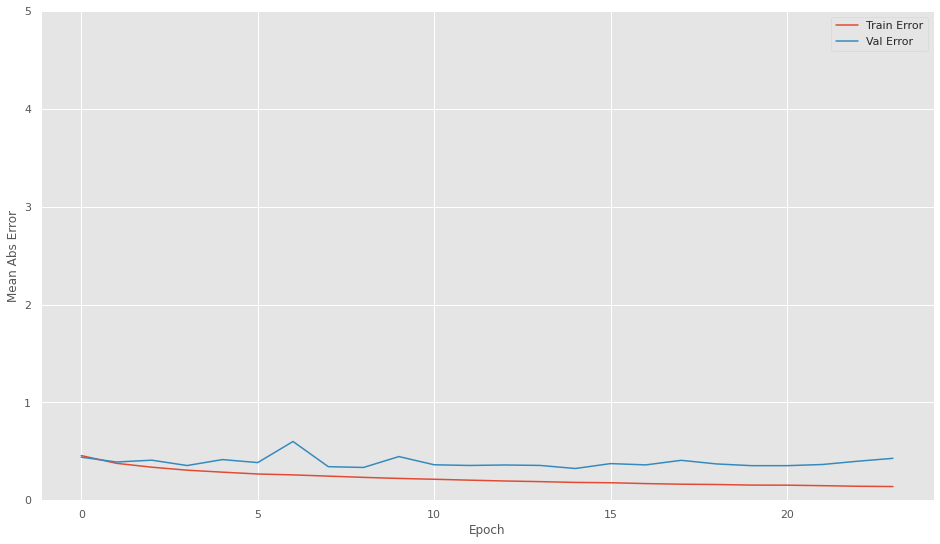

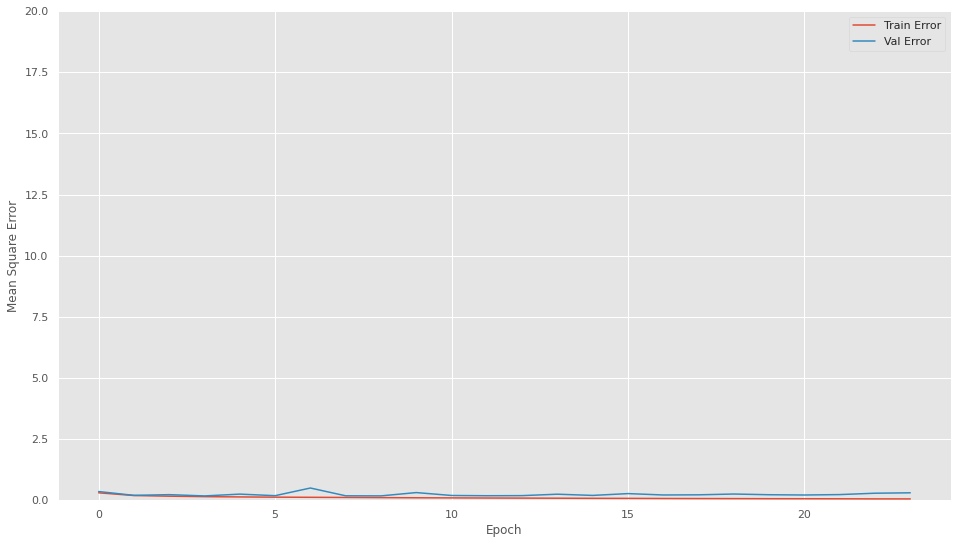

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
preds = model.predict(np.asarray(test_set)).round()
result['target'] = preds
print(F1(result))


1199.0 935.0 204.0
0.6779756856092735


# TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag', C=10)
classifier.fit(train_set, train_label)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = classifier.predict(test_set)
result['target'] = preds
print(F1(result))

768.0 281.0 634.0
0.6266829865361077


# LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:

param ={'num_leaves': list(range(5,50,12)), 
        'min_child_samples': list(range(100,300,50)), 
        'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
        'subsample': np.arange(0.2,0.8,0.2).tolist(), 
        'colsample_bytree': np.arange(0.3,0.7,0.1).tolist(),
        'reg_alpha': [0, 1, 5, 10, 50],
        'reg_lambda': [0, 1, 5, 10, 50]
}

params = ['num_leaves', 
          'min_child_samples', 
          'min_child_weight', 
          'subsample', 
          'colsample_bytree', 
          'reg_alpha', 
          'reg_lambda',
          'num_boost_round'
]

#los rangos se van afinando segun corren las pruebas
def busqueda_de_hiperparametros_optimos_LightGBM_busqueda_binaria():
    parametros_num_boost_round = list(range(50,151,22))
    #parametros_early_stopping_rounds = list(range(10,51,10))
    listaDeParametros = [param['num_leaves'],
                         param['min_child_samples'],
                         param['min_child_weight'],
                         param['subsample'],
                         param['colsample_bytree'],
                         param['reg_alpha'],
                         param['reg_lambda'],
                         parametros_num_boost_round]
    #print(listaDeParametros[0:6])
    max,parametros =busqueda_binaria_de_maximo(listaDeParametros,
                                                   [0,0,0,0,0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_LigthBM)
    print("maximo {} parametros ({}) {}".format(max,params, parametros))
busqueda_de_hiperparametros_optimos_LightGBM_busqueda_binaria()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_label, test_size=0.2, random_state=33)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)


params = {
    'objective': 'regression',
    'num_leaves':17, 
    'min_child_samples':150, 
    'min_child_weight':100, 
    'subsample':0.8, 
    'colsample_bytree':0.6, 
    'reg_alpha':5, 
    'reg_lambda':5,
    'num_boost_round':138
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_valid,
                early_stopping_rounds=40)

[1]	valid_0's l2: 0.245291
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's l2: 0.243133
[3]	valid_0's l2: 0.241701
[4]	valid_0's l2: 0.240451
[5]	valid_0's l2: 0.238837
[6]	valid_0's l2: 0.237265
[7]	valid_0's l2: 0.235619
[8]	valid_0's l2: 0.23437
[9]	valid_0's l2: 0.234156
[10]	valid_0's l2: 0.233348
[11]	valid_0's l2: 0.232325
[12]	valid_0's l2: 0.231457
[13]	valid_0's l2: 0.231165
[14]	valid_0's l2: 0.230864
[15]	valid_0's l2: 0.23078
[16]	valid_0's l2: 0.230616
[17]	valid_0's l2: 0.229909
[18]	valid_0's l2: 0.229614
[19]	valid_0's l2: 0.229234
[20]	valid_0's l2: 0.229115
[21]	valid_0's l2: 0.22904
[22]	valid_0's l2: 0.22851
[23]	valid_0's l2: 0.228265
[24]	valid_0's l2: 0.228169
[25]	valid_0's l2: 0.22813
[26]	valid_0's l2: 0.227766
[27]	valid_0's l2: 0.227662
[28]	valid_0's l2: 0.227327
[29]	valid_0's l2: 0.227214
[30]	valid_0's l2: 0.227066
[31]	valid_0's l2: 0.227063
[32]	valid_0's l2: 0.227091
[33]	valid_0's l2: 0.226844
[34]	valid_0's l2: 0.22676
[

In [ ]:
preds = gbm.predict(test_set, num_iteration=gbm.best_iteration).round()
result['target'] = preds
print(F1(result))

resultados_de_prediccion = copy.deepcopy(result)
print(f1(preds))

619 412 783
0.5088368269625976
0.633772601900092


Grid-Search

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(train_set, train_label, test_size=0.20, random_state=314, stratify=train_label)

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
opt_parameters = gs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's auc: 0.640686
Early stopping, best iteration is:
[77]	valid's auc: 0.641482
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.643998
Early stopping, best iteration is:
[104]	valid's auc: 0.644551
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.649568
Early stopping, best iteration is:
[77]	valid's auc: 0.650669
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.64274
[200]	valid's auc: 0.644302
Early stopping, best iteration is:
[224]	valid's auc: 0.644687
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.64307
Early stopping, best iteration is:
[153]	valid's auc: 0.646437
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.646532
[200]	valid's auc: 0.648166
Early stopping, best iteration is:
[220]	valid's auc: 0.648284
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


Early stopping, best iteration is:
[38]	valid's auc: 0.662511
Best score reached: 0.6717501428799296 with params: {'colsample_bytree': 0.952164731370897, 'min_child_samples': 111, 'min_child_weight': 0.01, 'num_leaves': 38, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.3029313662262354} 


In [ ]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.952164731370897, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=111, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=38, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0.1, silent=True,
               subsample=0.3029313662262354, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True,
                                return_train_score=True)

In [ ]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Early stopping, best iteration is:
[49]	valid's auc: 0.659731
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[35]	valid's auc: 0.662628
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[33]	valid's auc: 0.653401
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.665704
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[51]	valid's auc: 0.653191
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[27]	valid's auc: 0.658913
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.657799
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	valid's auc: 0.65354
Training until validation scores don't improve for 30 rounds.
Early sto

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.3s finished


[100]	valid's auc: 0.663075
Early stopping, best iteration is:
[71]	valid's auc: 0.66497
Best score reached: 0.6752985728495133 with params: {'scale_pos_weight': 6} 


In [ ]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.672+-0.014     0.759   :  {'scale_pos_weight': 12}
0.674+-0.012     0.761   :  {'scale_pos_weight': 1}
0.675+-0.011     0.754   :  {'scale_pos_weight': 2}
0.675+-0.012     0.767   :  {'scale_pos_weight': 6}


In [ ]:
clf_final = lgb.LGBMClassifier(**clf.get_params())

#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[27]	valid's auc: 0.659473


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.952164731370897, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=111, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=38, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0.1, silent=True,
               subsample=0.3029313662262354, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
probabilities = clf_final.predict_proba(test_set, axis=1) + 0.012
result['target'] = [ row[1].round() for row in probabilities]
print(F1(result))

639.0 441.0 763.0
0.5149073327961322


# ENTREGA

In [ ]:
submit_path = 'gdrive/My Drive/Colab Notebooks/TP2-7506-Datos-master/submit.csv'
resultados_de_prediccion = resultados_de_prediccion.reset_index()
resultados_de_prediccion.shape

(3263, 2)

In [ ]:
#resultados_de_prediccion.columns = ['id','target']
resultados_de_prediccion['target'] = resultados_de_prediccion['target'].astype(int)
resultados_de_prediccion['target'].value_counts()

0    1961
1    1302
Name: target, dtype: int64

In [ ]:
#cuando todo termina el archivo de entrega
resultados_de_prediccion.to_csv(submit_path, index=False)